In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define MoCo model
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=65536, m=0.999, T=0.07):
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # Create the encoders
        # Encoder q
        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)

        # Initialize the key encoder parameters to the same values as the query encoder
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

    def forward(self, im_q, im_k):
        # Compute query features
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # Compute key features
        with torch.no_grad():
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        return q, k

def load_model(model_path):
    model = MoCo(base_encoder=models.resnet18, dim=128)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
    model.eval()
    return model

# Load the model
model_path = '/Users/nithinrajulapati/Downloads/PROJECT 1/output/geography_aware_model.pth'
model = load_model(model_path)


In [3]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image

# Example image path
image_path = '/Users/nithinrajulapati/Downloads/PROJECT 1/output/images/animal/Dog exiting the St Lawrence River_53844813150.jpg'
image = preprocess_image(image_path)


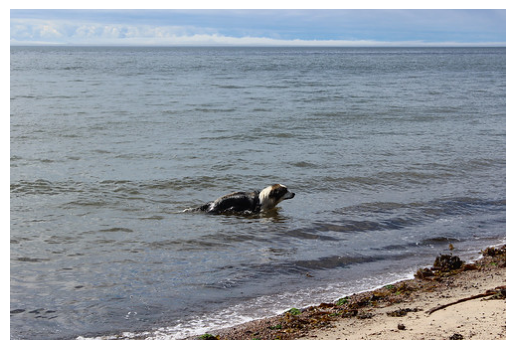

In [4]:
# Function to display image
def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Display the example image
show_image(image_path)


In [5]:
def predict(model, image):
    with torch.no_grad():
        output = model(image, image)  # assuming a dummy image for im_k
        q, k = output
        _, pred = torch.max(q, 1)
        return pred.item()

# Make prediction
prediction = predict(model, image)
print(f'Predicted class: {prediction}')


Predicted class: 45


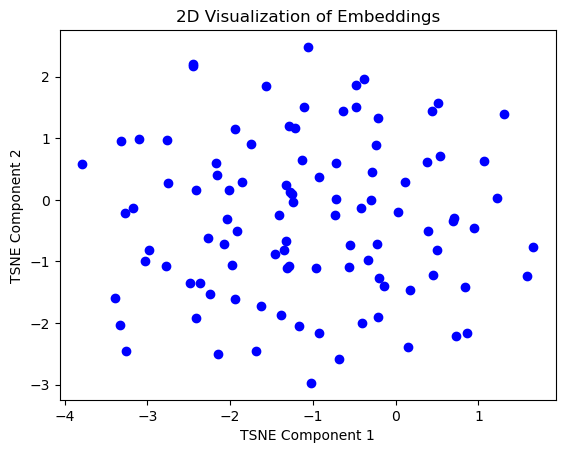

In [6]:
from sklearn.manifold import TSNE

# Dummy embeddings for visualization
embeddings = torch.randn(100, 128)  # replace with actual embeddings if available

# Perform TSNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue')
plt.title('2D Visualization of Embeddings')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()
